In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import optimize, stats


from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import sys
import multiprocessing as mp

from Bio import SeqIO, SeqUtils
import math
import time

In [3]:
sys.path.append("./mean_field_electrostatics/v2/")
import base_classes
import morbidelli as m
import hubbuch as h
import hsu
import misc_functions as misc

sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

# Function for estimating net charge

In [4]:
def get_charge(pH, seq):
    sol = base_classes.solution(pH, ion_str=0.1)
    pro = m.protein(sol, seq=seq, dpr=2.0e-10, negative_sign=True)      
    return pro.net_charge

# SDM parameter correlation

In [5]:
df_2_fit_parms = pd.read_csv('./lit_data/two_params_without_my_data.csv')
df_2_fit_parms['ln_a'] = np.log(df_2_fit_parms.a)

df_lge = pd.read_csv('./lit_data/gradient_data.csv')

In [6]:
def instantiate_fig(x=7, y=6):
    fig, ax = plt.subplots()
    fig.set_size_inches(x, y, forward=True)
    font = {'weight' : 'normal', 'size'   : 20}
    plt.rc('font', **font)
    return fig, ax

def set_layout(fig, ax, legend=False):
    if legend:
        ax.legend(loc='best', handlelength=1, frameon=False)
    fig.patch.set_alpha(1)
    plt.tight_layout()
    return

def get_reg_intervals(x, y, alpha=0.05, line_extension=0.0):
    slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment
    y_model = np.polyval([slope, intercept], x)   # modeling...

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                        # number of samples
    m = 2                             # number of parameters
    dof = n - m                       # degrees of freedom
    t = stats.t.ppf(1.0-alpha/2.0, dof) # Students statistic of interval confidence

    residual = y - y_model
    std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

    # mean squared error
    MSE = 1/n * np.sum( residual**2 )

    # to plot the adjusted model
    x_line = np.linspace(np.min(x)-line_extension, np.max(x)+line_extension, 1000)
    y_line = np.polyval([slope, intercept], x_line)

    # intervals
    ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
    pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  
    pred_err_var = (std_error**2.0) * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))
    
    return x_line, y_line, ci, pi, pred_err_var

def get_pred_err_var(x, y, x_star):
    slope, intercept = np.polyfit(x, y, 1)  
    y_model = np.polyval([slope, intercept], x)  
    residual = y - y_model

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                       
    m = 2                            
    dof = n - m   
    
    pred_err_var = (np.sum(residual**2) / dof) * (1 + 1/n + (x_star - x_mean)**2 / np.sum((x - x_mean)**2))
    return pred_err_var
    
def plot_intervals(x, y, x_line, y_line, ci, pi):
    fig, ax = instantiate_fig()
    ax.set_xlabel('$a$')
    ax.set_ylabel('$b$')
    ax.set_xscale('log')
    
    color = 'blue'
    ax.plot(np.exp(x), y, 'o', color = 'royalblue')
    ax.plot(np.exp(x_line), y_line, color = 'royalblue', linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = 'lightcyan', label = '95% PI')
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = 'skyblue', label = '95% CI')
#     ax.legend(loc='upper right', fontsize=20)

    return fig, ax

def plot_intervals_reverse(x, y, x_line, y_line, ci, pi):
    fig, ax = instantiate_fig()
    ax.set_xlabel('$b$')
    ax.set_ylabel('$a$')
    ax.set_yscale('log')
    
    color = 'blue'
    ax.plot(x, np.exp(y), 'o', color = 'royalblue')
    ax.plot(x_line, np.exp(y_line), color = 'royalblue', linestyle='--')
    ax.fill_between(x_line, np.exp(y_line + pi), np.exp(y_line - pi), color = 'lightcyan', label = '95% PI')
    ax.fill_between(x_line, np.exp(y_line + ci), np.exp(y_line - ci), color = 'skyblue', label = '95% CI')
    ax.legend(loc='upper right', fontsize=20)

    return fig, ax

def plot_intervals_reverse_ln(x, y, x_line, y_line, ci, pi):
    fig, ax = instantiate_fig()
    ax.set_xlabel('$b$')
    ax.set_ylabel('$ln(a)$')
    
    color = 'blue'
    ax.plot(x, y, 'o', color = 'royalblue')
    ax.plot(x_line, y_line, color = 'royalblue', linestyle='--')
    ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% PI')
    ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% CI')
    ax.legend(loc='lower left', fontsize=16)

    return fig, ax

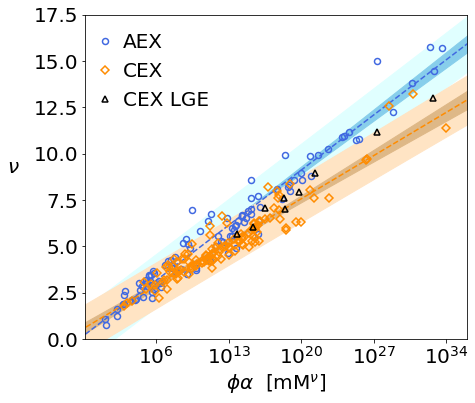

In [8]:
fig, ax = instantiate_fig()
ax.set_xlabel(r'$\phi \alpha$  [mM$^\nu$]')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)

ax.set_xscale('log')
ax.set_xlim(np.exp(-2), np.exp(83))
ax.set_ylim(0, 17.5)

# iex_type_list = ['cex', 'aex']
iex_type_list = ['aex', 'cex']

for iex_type in iex_type_list:
    df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

    data = np.zeros((len(df), 2))
    data[:,0] = df.ln_a
    data[:,1] = -1*df.b

    x = data[:,0]
    y = data[:,1]

    x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=10.0)
    
    if iex_type == 'aex':
        color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
        marker = 'o'
    elif iex_type == 'cex':
        color_1, color_2, color_3 = 'darkorange', 'burlywood', 'bisque'
        marker = 'D'
    
    ax.plot(np.exp(x), y, marker, color = color_1, label=iex_type.upper(), 
            fillstyle='none', markeredgewidth=1.5)
    ax.plot(np.exp(x_line), y_line, color = color_1, linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = color_3)
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = color_2)

ax.plot(df_lge.phi_alpha, df_lge.nu, '^', color='black', label='CEX LGE', 
       fillstyle='none', markeredgewidth=1.5)

ax.legend(loc='upper left', handlelength=0.2, frameon=False)
set_layout(fig, ax)
# fig.savefig(f'./images/manuscript_images/sdm_parameter_correlation.pdf')
# fig.savefig('./images/manuscript_images/sdm_parameter_correlation.png', dpi=300)

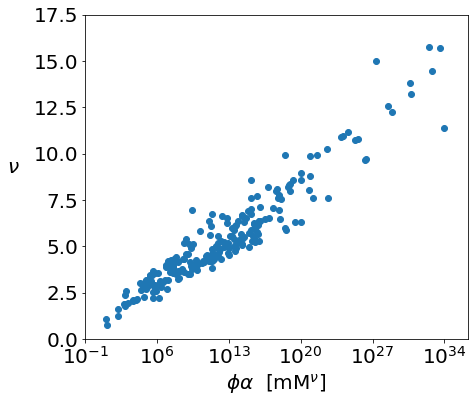

In [14]:
fig, ax = instantiate_fig()
ax.set_xlabel(r'$\phi \alpha$  [mM$^\nu$]')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)
ax.set_xscale('log')
ax.set_xlim(1e-1, 2e36)
ax.set_ylim(0, 17.5)

ax.scatter(np.exp(df_2_fit_parms.ln_a), -1*df_2_fit_parms.b)
set_layout(fig, ax)


# New work

In [29]:
df_2_fit_parms['nu'] = -1*df_2_fit_parms.b

In [32]:
proteins = list(set(df_2_fit_parms.protein))
proteins.sort()
proteins

['FGF-1',
 'FGF-2',
 'alpha-chymotrypsinogen A',
 'alpha-lactalbumin',
 'anti-FVII mAb',
 'aprotinin',
 'cytochrome c',
 'lipolase',
 'lysozyme',
 'mAb basic variant',
 'mAb main variant',
 'myoglobin',
 'pepsinogen']

In [33]:
combos = list(set(zip(df_2_fit_parms.protein, df_2_fit_parms.pH, df_2_fit_parms.data_set, )))
combos.sort()
for i, c in enumerate(combos):
    print(i, '\t', c)

0 	 ('FGF-1', 7.0, 'DePhillips')
1 	 ('FGF-2', 7.0, 'DePhillips')
2 	 ('alpha-chymotrypsinogen A', 7.0, 'DePhillips')
3 	 ('alpha-lactalbumin', 0.0, 'bai')
4 	 ('anti-FVII mAb', 5.5, 'Staby')
5 	 ('anti-FVII mAb', 8.0, 'Staby')
6 	 ('aprotinin', 5.5, 'Staby')
7 	 ('aprotinin', 9.0, 'Staby')
8 	 ('cytochrome c', 7.0, 'DePhillips')
9 	 ('lipolase', 8.0, 'Staby')
10 	 ('lysozyme', 5.5, 'Staby')
11 	 ('lysozyme', 7.0, 'DePhillips')
12 	 ('mAb basic variant', 6.5, 'kumar')
13 	 ('mAb basic variant', 7.0, 'kumar')
14 	 ('mAb main variant', 6.5, 'kumar')
15 	 ('mAb main variant', 7.0, 'kumar')
16 	 ('myoglobin', 5.5, 'Staby')
17 	 ('myoglobin', 9.0, 'Staby')
18 	 ('pepsinogen', 0.0, 'bai')


In [25]:
df_2_fit_parms[df_2_fit_parms.protein == 'alpha-lactalbumin']

,data_set,iex_type,resin,protein,pH,a,b,ln_a,nu
12,bai,aex,Fractogel EMD DEAE (M),alpha-lactalbumin,0.0,2.750328e+06,-2.820816,14.827231,2.820816
44,bai,aex,Toyopearl DEAE 650 M,alpha-lactalbumin,0.0,1.393205e+05,-2.856289,11.844533,2.856289
85,bai,aex,Fractogel EMD DMAE (M),alpha-lactalbumin,0.0,4.108727e+05,-2.515395,12.926039,2.515395
94,bai,aex,Toyopearl SuperQ 650m,alpha-lactalbumin,0.0,6.807466e+05,-2.667803,13.430945,2.667803
148,bai,aex,DEAE Sepharose FF,alpha-lactalbumin,0.0,2.145999e+06,-2.998210,14.579116,2.998210
219,bai,aex,Q Sepharose FF,alpha-lactalbumin,0.0,7.527438e+07,-3.593757,18.136650,3.593757
228,bai,aex,Fractogel EMD TMAE,alpha-lactalbumin,0.0,5.847650e+04,-2.274022,10.976380,2.274022


In [26]:
df_2_fit_parms[df_2_fit_parms.protein == 'pepsinogen']

,data_set,iex_type,resin,protein,pH,a,b,ln_a,nu
1,bai,aex,Fractogel EMD TMAE,pepsinogen,0.0,7.240285e+09,-3.723251,22.702926,3.723251
39,bai,aex,Toyopearl DEAE 650 M,pepsinogen,0.0,4.316800e+05,-2.206629,12.975440,2.206629
88,bai,aex,Toyopearl SuperQ 650m,pepsinogen,0.0,7.897601e+15,-6.379148,36.605335,6.379148
93,bai,aex,Fractogel EMD DMAE (M),pepsinogen,0.0,4.803188e+13,-4.895038,31.502886,4.895038
144,bai,aex,DEAE Sepharose FF,pepsinogen,0.0,9.809377e+08,-3.514762,20.704020,3.514762
166,bai,aex,Fractogel EMD DEAE (M),pepsinogen,0.0,6.921611e+15,-5.660599,36.473425,5.660599
223,bai,aex,Q Sepharose FF,pepsinogen,0.0,8.181205e+12,-4.647687,29.732861,4.647687
